In [12]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:
#First some functions that will be useful...

def initialize_data(dum=True):
    """
    Import and prepare the dataset adding log variables, and an incercept.
    """
    #Import data file
    df = pd.read_stata("exam1.dta")
    df.to_csv("exam1.dta".replace(".dta", ".csv"))    

    #Add log variables
    df['log_rK'] = np.log10(df['rK'])
    df['log_routput'] = np.log10(df['routput'])
    df['log_emp'] = np.log10(df['emp'])

    #Add intercept
    df['intercept'] = 1
    return df

#Add dummies function
def add_dummy(dataframe, column):
    """
    Add dummies to 'dataframe' accounting for 'column'
    """
    s = pd.Series(list(column))
    dum = pd.get_dummies(s)
    return pd.concat([dataframe,dum], axis = 1)

def OLS(X, y):
    """
    Run OLS and show summary
    """ 
    model = sm.OLS(y, X)
    results = model.fit()
    return results

def make_plot(beta, x, y, z, elev=30., azim=120, xlab = 'log_rK', ylab = 'log_emp', zlab = 'log_routput'):
    """
    When fitting with two variables, show 3D plot of data and linear (plane) fit.
    """ 
    #create grid
    X,Y = np.meshgrid(np.arange(min(x), max(x), 0.1), np.arange(min(y), max(y), 0.1))
    XX = X.flatten()
    YY = Y.flatten()

    # evaluate it on grid
    Z = beta[xlab]*X + beta[ylab]*Y + beta['intercept']

    # plot points and fitted surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
    ax.scatter(x, y, z, c='r', s=50)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    ax.set_zlabel(zlab)
    ax.axis('equal')
    ax.axis('tight')
    ax.view_init(elev=elev, azim=azim)
    plt.show()

                            OLS Regression Results                            
Dep. Variable:            log_routput   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     734.6
Date:                Sat, 01 Apr 2017   Prob (F-statistic):               0.00
Time:                        21:26:54   Log-Likelihood:                 7349.3
No. Observations:                6500   AIC:                        -1.467e+04
Df Residuals:                    6485   BIC:                        -1.457e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
1990.0        -0.0887      0.003    -25.653      0.0

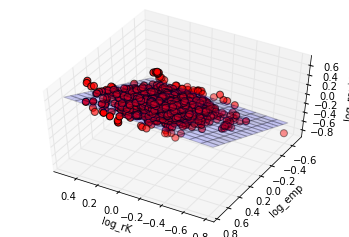

In [80]:
"""
WITHIN GROUP / FIXED EFFECTS ESTIMATOR
"""

#Useful to have group means
means = initialize_data().groupby(['id']).transform('mean')
    
#Transform for Within / FE
df_fe = initialize_data()
df_fe[['log_routput','log_rK','log_emp']]=df_fe[['log_routput','log_rK','log_emp']]-means[['log_routput','log_rK','log_emp']]
df_fe = add_dummy(df_fe,df_fe['year'])

results_fe = OLS(df_fe[df_fe.columns.difference(['id','year','rK','routput','emp','sector','indu','log_routput'])], df_fe['log_routput'])

print results_fe.summary()

make_plot(results_fe.params, df_fe['log_rK'], df_fe['log_emp'], df_fe['log_routput'], elev = 50.) #'elev' changes angle

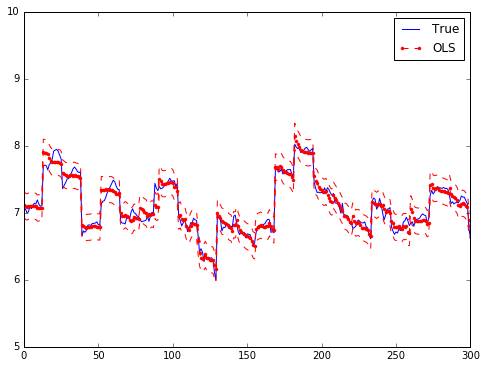

In [8]:
"""
POOLED
"""

#Add dummies for year and id
df = initialize_data()
df_dum = add_dummy(df,df['year'])
df_dum = add_dummy(df,df['id'])

#Run regression
results_ols = OLS(df_dum[df_dum.columns.difference(['id','year','rK','routput','emp','sector','indu','log_routput'])], df['log_routput'])


#Confidence band
prstd, iv_l, iv_u = wls_prediction_std(results_ols)

#Show results. X value span may be changed...
fig, ax = plt.subplots(figsize=(8,6))
x = range(len(df_dum))
ax.plot(x, df['log_routput'], 'b-', label="True")
ax.plot(x, results_ols.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best')
plt.xlim((0,300)) #Change X limits
plt.show()


                            OLS Regression Results                            
Dep. Variable:            log_routput   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1533.
Date:                Sat, 01 Apr 2017   Prob (F-statistic):               0.00
Time:                        20:29:21   Log-Likelihood:                 3990.9
No. Observations:                6500   AIC:                            -7952.
Df Residuals:                    6485   BIC:                            -7850.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
1990.0         0.0182      0.006      3.130      0.0

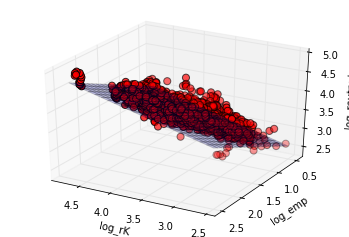

In [9]:
"""
RANDOM EFFECTS ESTIMATOR
"""

#Random effects

#First use results of OLS to get theta (th)
sigma2_e = np.var(df_fe['log_routput']-results_ols.fittedvalues)
sigma2_a = np.var(results_ols.params[range(0,500)])
T = len(list(set(df['year'])))
th = 1 - np.sqrt(sigma2_e/(sigma2_e + T * sigma2_a))

#Transform for Random
df_re = initialize_data()
df_re[['log_routput','log_rK','log_emp']]=df[['log_routput','log_rK','log_emp']]- th*means[['log_routput','log_rK','log_emp']]
df_re = add_dummy(df_re,df_re['year'])

results_re = OLS(df_re[df_re.columns.difference(['id','year','rK','routput','emp','sector','indu','log_routput'])], df_re['log_routput'])

print results_re.summary()

make_plot(results_re.params, df_re['log_rK'], df_re['log_emp'], df_re['log_routput'])


                            OLS Regression Results                            
Dep. Variable:            log_routput   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     1181.
Date:                Mon, 27 Mar 2017   Prob (F-statistic):          1.46e-189
Time:                        19:37:35   Log-Likelihood:                 100.23
No. Observations:                 500   AIC:                            -194.5
Df Residuals:                     497   BIC:                            -181.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept      2.2058      0.125     17.613      0.0

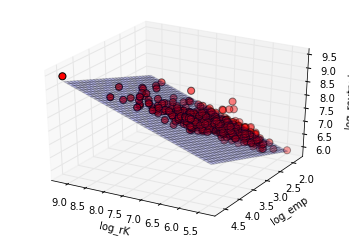

In [6]:
"""
BETWEEN EFFECTS ESTIMATOR
"""

#Transform for Between
df_be = initialize_data().groupby(['id'], axis=0).mean()

results_be = OLS(df_be[['intercept','log_rK','log_emp']], df_be['log_routput'])
print results_be.summary()
make_plot(results_be.params, df_be['log_rK'], df_be['log_emp'], df_be['log_routput'])


(0.01, 1)

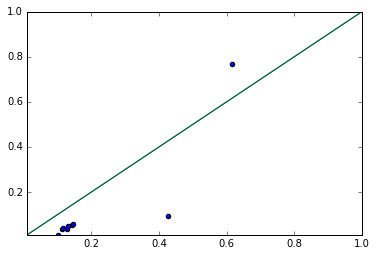

In [77]:
"""
HAUSMAN TEST

    The null hypothesis (p < 0.05) supports the claim that the random effects
    estimator is consistent, and hence we would pick it for being the most efficient. 
    If we reject this hypothesis it is the same as saying we should be using fixed effects because there are
    systematic differences in the coefficients.
    
"""

# First compare both results:
plt.scatter(results_re.params, results_fe.params)
plt.plot([(0,0), (1,1)])
# plt.yscale('log')
# plt.xscale('log')
plt.ylim((0.01,1))
plt.xlim((0.01,1))

#It may be the case that there are sistematic differences, i.e. one of the two is not consistent.

In [78]:
"""
HAUSMAN TEST 1

    Method based on https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py
   
"""

# Pull data out
params_diff = results_re.params - results_fe.params

#Degrees of freedom
dof = results_fe.params[np.abs(results_fe.params) < 1e8].size

v_B = results_re.cov_params()
v_b = results_fe.cov_params()

# compute test statistic
chi2 = T*np.dot(params_diff, np.linalg.pinv(v_B - v_b).dot(params_diff))

# chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
pval = stats.chi2.sf(chi2, dof)

print 'Method 1:'
print dict({'chi2': chi2,'pval': pval})

"""
HAUSMAN TEST 2 (normalized covariances)

    Method based on the source code for statsmodels.sandbox.regression.gmm
   
"""
from statsmodels.compat.numpy import np_matrix_rank

endog, exog = results_fe.model.endog_names, results_fe.model.exog_names

params_diff = results_re.params - results_fe.params

# Sum of squared (whitened) residuals / 1 endogenous vars (log_routput)
se2 = results_fe.ssr / len(endog)

cov_diff = results_re.normalized_cov_params - results_fe.normalized_cov_params
# plt.matshow(cov_diff)
# print cov_diff
cov_diffpinv = np.linalg.pinv(cov_diff)

#Degrees of freedom
dof = np_matrix_rank(cov_diff)

chi2 = np.dot(params_diff, np.dot(cov_diffpinv, params_diff))/se2
pval = stats.chi2.sf(chi2, dof)

print 'Method 2:'
print dict({'chi2': chi2,'pval': pval})

Method 1:
{'chi2': 72380.95947265625, 'pval': 0.0}
Method 2:
{'chi2': 4.4968433385252649, 'pval': 0.21257202724043761}


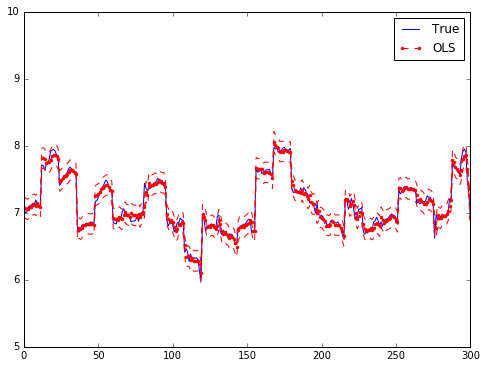

In [43]:
"""
LAGGED T-1
"""

#Add dummies for year and id
df = initialize_data()
df_lag = add_dummy(df,df['year'])
df_lag = add_dummy(df,df['id'])

#Add lagged
df_lag["log_routput_lag1"] = df_lag["log_routput"].shift()
df_lag = df_lag[df_lag['year'] != 1990] #Remove first entries


results_ols = OLS(df_lag[df_lag.columns.difference(['id','year','rK','routput','emp','sector','indu','log_routput'])], df_lag['log_routput'])

#Plot   
prstd, iv_l, iv_u = wls_prediction_std(results_ols)

fig, ax = plt.subplots(figsize=(8,6))

x = range(len(df_lag))
ax.plot(x, df_lag['log_routput'], 'b-', label="True")
ax.plot(x, results_ols.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best')
plt.xlim((0,300))
plt.show()